# <span style='background:Yellow'> Bottom Temp & Salt difference between ECCO and WOA

In [1]:
from dask.distributed import Client

client = Client("tcp://10.32.16.95:35191")
client

Client Scheduler: tcp://10.32.16.95:35191 Dashboard: /user/0000-0002-8176-9465/proxy/8787/status,Cluster Workers: 19 Cores: 38 Memory: 218.50 GB


In [2]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
%matplotlib inline
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import regionmask
import geopandas
import scipy
import xesmf as xe

/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['geojson', 'postgis', 'shapefile', 'spatialite'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [3]:
xr.set_options(display_style='text')

In [4]:
woa8110_pt = xr.open_dataset('/home/jovyan/WMT/WOA/pt_bottom_wg_8110.nc')
woa0517_pt = xr.open_dataset('/home/jovyan/WMT/WOA/pt_bottom_wg_0517.nc')
ecco_temp = xr.open_dataset('/home/jovyan/WMT/ECCO-budgets/bottom_temp_wg.nc')
ecco_slt = xr.open_dataset('/home/jovyan/WMT/ECCO-budgets/bottom_slt_wg.nc')

### <span style='color:Brown'> Interpolating WOA (1981-2010) temp data onto ECCO's grid

In [5]:
ecco_temp

<xarray.Dataset>
Dimensions:  (i: 95, j: 50, time: 288)
Coordinates:
    k        (j, i) int64 ...
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * i        (i) int64 333 334 335 336 337 338 339 340 ... 61 62 63 64 65 66 67
  * j        (j) int64 30 31 32 33 34 35 36 37 38 ... 71 72 73 74 75 76 77 78 79
    lat      (j, i) float32 ...
    lon      (j, i) float32 ...
Data variables:
    THETA    (time, j, i) float32 ...

In [6]:
woa8110_pt

<xarray.Dataset>
Dimensions:  (lat: 19, lon: 96, time: 1)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-15
    lev      (time, lat, lon) float64 ...
  * lat      (lat) float64 -79.5 -78.5 -77.5 -76.5 ... -64.5 -63.5 -62.5 -61.5
  * lon      (lon) float64 -64.5 -63.5 -62.5 -61.5 -60.5 ... 27.5 28.5 29.5 30.5
Data variables:
    PT       (time, lat, lon) float64 ...

In [7]:
regridder = xe.Regridder(woa8110_pt, ecco_temp, method='bilinear')
regridder

Create weight file: bilinear_19x96_50x95.nc


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_19x96_50x95.nc 
Reuse pre-computed weights? False 
Input grid shape:           (19, 96) 
Output grid shape:          (50, 95) 
Output grid dimension name: ('j', 'i') 
Periodic in longitude?      False

In [8]:
woa8110_pt_new_grid = regridder(woa8110_pt)
woa8110_pt_new_grid

using dimensions ('lat', 'lon') from data variable PT as the horizontal dimensions for this dataset.


<xarray.Dataset>
Dimensions:  (i: 95, j: 50, time: 1)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-15
    lon      (j, i) float32 -71.48463 -70.462875 -69.43226 ... 27.5 28.5 29.5
    lat      (j, i) float32 -80.06884 -80.13835 ... -62.216576 -62.216576
Dimensions without coordinates: i, j
Data variables:
    PT       (time, j, i) float64 0.0 0.0 0.0 0.0 ... -0.7204 -0.7081 -0.6951
Attributes:
    regrid_method:  bilinear

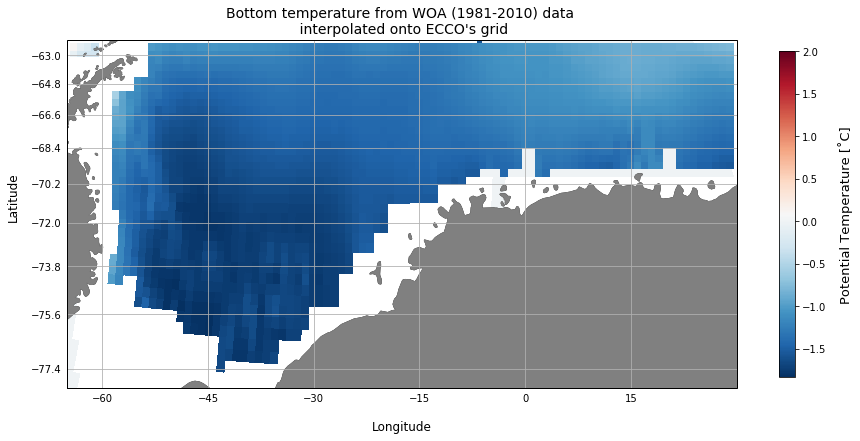

In [9]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
#ax.add_feature(cfeature.LAND, facecolor='0.8', edgecolor='k')

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))

im = ax.pcolormesh(woa8110_pt_new_grid.lon, 
                   woa8110_pt_new_grid.lat, 
                   woa8110_pt_new_grid.PT[0], transform=ccrs.PlateCarree(), cmap='RdBu_r', vmax=2)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Potential Temperature [˚C]", labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title("Bottom temperature from WOA (1981-2010) data \n interpolated onto ECCO's grid", fontsize=14);

## <span style='background:Yellow'> <font color='Red'> Bottom temperature `ECCO - WOA` (1981-2010) </font>

In [11]:
ecco_temp = ecco_temp.THETA.mean(dim='time')
ecco_temp

<xarray.DataArray 'THETA' (j: 50, i: 95)>
array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.5656109 ,  1.8291065 ,  1.6809775 , ..., -0.60746783,
        -0.60745776, -0.6074615 ],
       [ 0.13080378,  0.25096482,  1.8400244 , ..., -0.60863906,
        -0.6083164 , -0.608207  ],
       [ 0.12459682,  0.0798245 ,  0.19863093, ..., -0.61016595,
        -0.6093797 , -0.60912585]], dtype=float32)
Coordinates:
    k        (j, i) int64 ...
  * i        (i) int64 333 334 335 336 337 338 339 340 ... 61 62 63 64 65 66 67
  * j        (j) int64 30 31 32 33 34 35 36 37 38 ... 71 72 73 74 75 76 77 78 79
    lat      (j, i) float32 -80.06884 -80.13835 ... -62.216576 -62.216576
    lon      (j, i) float32 -71.48463 -70.462875 -69.43226 ... 27.5 28.5 29.5

In [19]:
#checking if nans
print(np.isnan(ecco_temp.sum()))

<xarray.DataArray 'THETA' ()>
array(False)


In [13]:
ecco_woa8110_diff = ecco_temp - woa8110_pt_new_grid.isel(time=0).PT
ecco_woa8110_diff

<xarray.DataArray (j: 50, i: 95)>
array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.63575033,  2.07516944,  1.94412458, ...,  0.25510106,
         0.2433311 ,  0.22895014],
       [ 0.03369812,  0.34266563,  2.02375475, ...,  0.1893589 ,
         0.17839337,  0.16403622],
       [-0.17822455, -0.03236783,  0.22024657, ...,  0.11020843,
         0.0987603 ,  0.0859307 ]])
Coordinates:
  * j        (j) int64 30 31 32 33 34 35 36 37 38 ... 71 72 73 74 75 76 77 78 79
  * i        (i) int64 333 334 335 336 337 338 339 340 ... 61 62 63 64 65 66 67
    k        (j, i) int64 ...
    lat      (j, i) float32 -80.06884 -80.13835 ... -62.216576 -62.216576
    lon      (j, i) float32 -71.48463 -70.462875 -69.43226 ... 27.5 28.5 29.5
    time     datetime64[ns] 2000-01-15

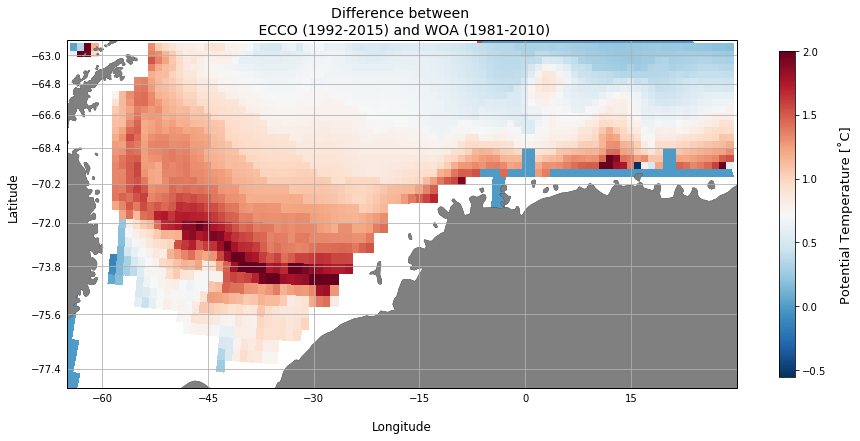

In [15]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
#ax.add_feature(cfeature.LAND, facecolor='0.8', edgecolor='k')

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))

im = ax.pcolormesh(ecco_woa8110_diff.lon, 
                   ecco_woa8110_diff.lat, 
                   ecco_woa8110_diff, transform=ccrs.PlateCarree(), cmap='RdBu_r', vmax=2)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Potential Temperature [˚C]", labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title("Difference between \n ECCO (1992-2015) and WOA (1981-2010)", fontsize=14);

### <span style='color:Brown'> Interpolating WOA (2005-2017) temp data onto ECCO's grid

In [20]:
regridder_2 = xe.Regridder(woa0517_pt, ecco_temp, method='bilinear')
regridder_2

Overwrite existing file: bilinear_19x96_50x95.nc 
 You can set reuse_weights=True to save computing time.


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_19x96_50x95.nc 
Reuse pre-computed weights? False 
Input grid shape:           (19, 96) 
Output grid shape:          (50, 95) 
Output grid dimension name: ('j', 'i') 
Periodic in longitude?      False

In [21]:
woa0517_pt_new_grid = regridder_2(woa0517_pt)
woa0517_pt_new_grid

using dimensions ('lat', 'lon') from data variable PT as the horizontal dimensions for this dataset.


<xarray.Dataset>
Dimensions:  (i: 95, j: 50, time: 1)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-15
    lon      (j, i) float32 -71.48463 -70.462875 -69.43226 ... 27.5 28.5 29.5
    lat      (j, i) float32 -80.06884 -80.13835 ... -62.216576 -62.216576
Dimensions without coordinates: i, j
Data variables:
    PT       (time, j, i) float64 0.0 0.0 0.0 0.0 ... -0.8279 -0.8171 -0.8026
Attributes:
    regrid_method:  bilinear

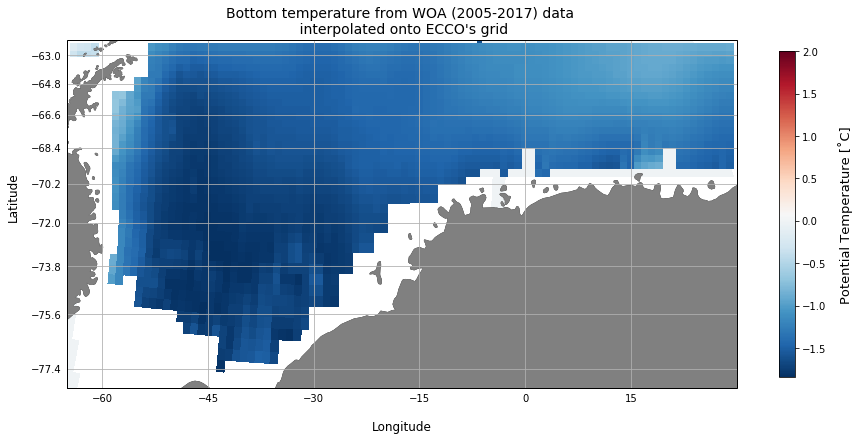

In [22]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
#ax.add_feature(cfeature.LAND, facecolor='0.8', edgecolor='k')

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))

im = ax.pcolormesh(woa0517_pt_new_grid.lon, 
                   woa0517_pt_new_grid.lat, 
                   woa0517_pt_new_grid.PT[0], transform=ccrs.PlateCarree(), cmap='RdBu_r', vmax=2)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Potential Temperature [˚C]", labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title("Bottom temperature from WOA (2005-2017) data \n interpolated onto ECCO's grid", fontsize=14);

## <span style='background:Yellow'> <font color='Red'> Bottom temperature `SOSE - WOA` (2005-2017) </font>

In [26]:
ecco_woa0517_diff = ecco_temp - woa0517_pt_new_grid.isel(time=0).PT
ecco_woa0517_diff

<xarray.DataArray (j: 50, i: 95)>
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.88361031, 2.24873682, 2.07543391, ..., 0.35274895, 0.3460978 ,
        0.33264542],
       [0.29412797, 0.52133069, 2.14992165, ..., 0.29290499, 0.28415616,
        0.27041006],
       [0.09586968, 0.16637828, 0.37163759, ..., 0.21770693, 0.20767789,
        0.19349591]])
Coordinates:
  * j        (j) int64 30 31 32 33 34 35 36 37 38 ... 71 72 73 74 75 76 77 78 79
  * i        (i) int64 333 334 335 336 337 338 339 340 ... 61 62 63 64 65 66 67
    k        (j, i) int64 ...
    lat      (j, i) float32 -80.06884 -80.13835 ... -62.216576 -62.216576
    lon      (j, i) float32 -71.48463 -70.462875 -69.43226 ... 27.5 28.5 29.5
    time     datetime64[ns] 2000-01-15

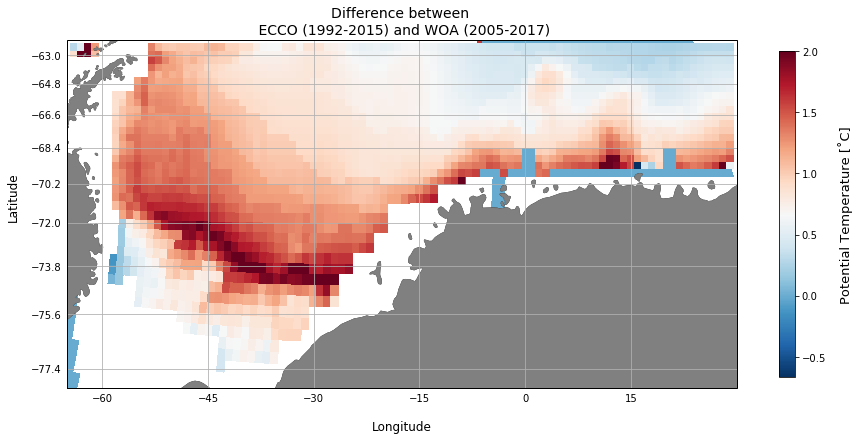

In [27]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
#ax.add_feature(cfeature.LAND, facecolor='0.8', edgecolor='k')

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))

im = ax.pcolormesh(ecco_woa0517_diff.lon, 
                   ecco_woa0517_diff.lat, 
                   ecco_woa0517_diff, transform=ccrs.PlateCarree(), cmap='RdBu_r', vmax=2)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Potential Temperature [˚C]", labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title("Difference between \n ECCO (1992-2015) and WOA (2005-2017)", fontsize=14);